# Brief Survey

In this notebook, I will perform a breif survey of the basic Fisher-KPP equation, ubiquitiously useful across various biological models, and how it behaves on some network topologies and some variables of interest.

## Demonstration

First, a breif demonstration on how the module works

In [1]:
import numpy as np 
from matplotlib import pyplot as plt
import networkx as nx
import DynaNet
import Equations

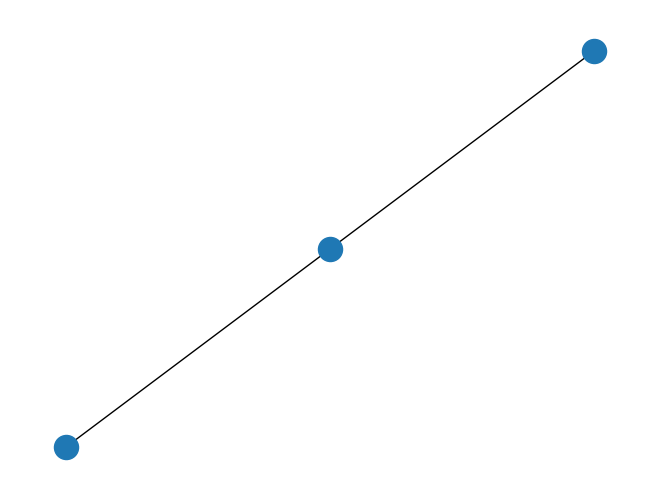

In [2]:
A = np.array([[0,1,0],
              [1,0,1],
              [0,1,0]
             ])

Netwk = DynaNet.DynaNet(adj_mtx=A)
DE = Equations.FisherKPPStep

# Vector of free parameters
ks = np.array([-0.65 for i in Netwk.vert])
vs = np.array([-0.4 for i in Netwk.vert])

# Initial parameters
f0 = [np.exp(-(i-0.5)**2) for i in Netwk.vert]
t0 = 0
tf = 10
nt = 1000

t = np.linspace(t0, tf, nt)

Netwk.solve_ivp(DE, f0, t0, tf, nt, ks, vs)
nx.draw(nx.from_numpy_matrix(A))

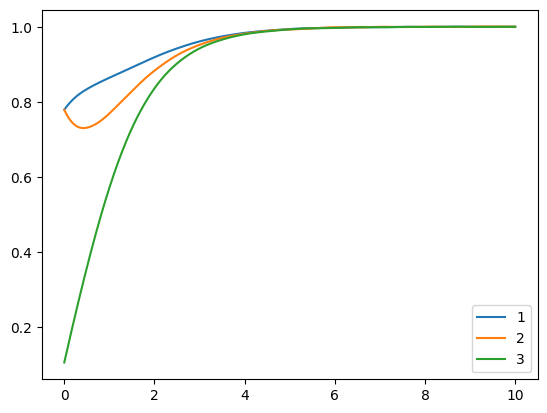

In [3]:
plt.plot(Netwk.solve_ivp_results.t, Netwk.solve_ivp_results.y[0,:], label='1')
plt.plot(Netwk.solve_ivp_results.t, Netwk.solve_ivp_results.y[1,:], label='2')
plt.plot(Netwk.solve_ivp_results.t, Netwk.solve_ivp_results.y[2,:], label='3')
plt.legend()
plt.show()

The above code displays the network in question and the dynamics on it as well as the time evolution of each node as it progresses towards equillibrium. 

# Random Graphs

The progress of each of these equations may depend on many parameters, up to and including the size of the network, how it was generated, the parameters it was initialized on, starting state and various graph properties. I will start with an Erdos-Renyi graph, that is a network of given sized generated by connecting nodes with probability $p$

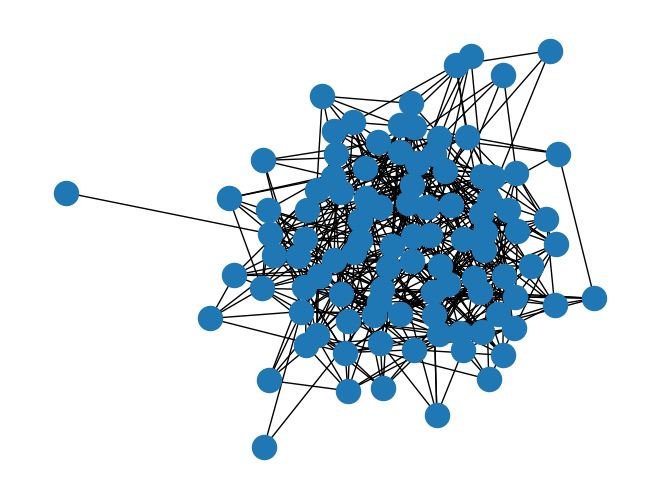

In [4]:
G = nx.erdos_renyi_graph(100,0.1)
nx.draw(G)

The topology of an ER graph is not representative of any particular system, but is very useful as a starting point for examining potential behaviour of random graphs in general. So, as a quick survey of behaviour, let's consider ER graphs with a few different sizes and probabilities. We'll iterate through sizes of 10, 100, and 500 with probabilities of 0.1, 0.5, and 0.9

[<DynaNet.DynaNet object at 0x000001C7264C3D48>, <DynaNet.DynaNet object at 0x000001C7264C3E48>, <DynaNet.DynaNet object at 0x000001C7264C3F08>, <DynaNet.DynaNet object at 0x000001C7265F3B88>, <DynaNet.DynaNet object at 0x000001C7265F35C8>, <DynaNet.DynaNet object at 0x000001C7264FB4C8>, <DynaNet.DynaNet object at 0x000001C7264FB588>, <DynaNet.DynaNet object at 0x000001C7262B5EC8>, <DynaNet.DynaNet object at 0x000001C727C6AA08>]


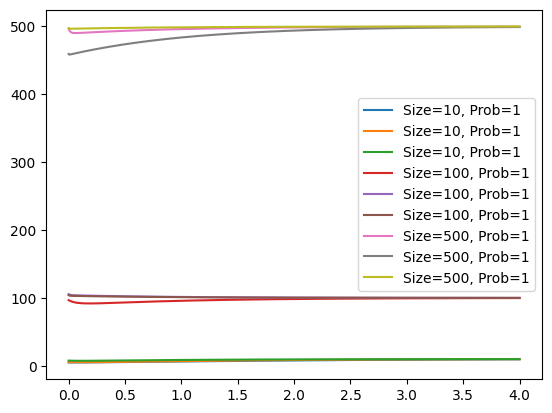

In [5]:
# Set up parameters for graphs
sizes = [10, 100, 500]
ps = [0.1, 0.5, 0.9]

# Set up parameters for PDE steps
k = -0.65
v = 0

# Initial values
t0 = 0
tf = 4
nt = 1000
t = np.linspace(t0, tf, nt)

# Generate dynamic graphs
Gs = [DynaNet.DynaNet(adj_mtx=nx.to_numpy_array(nx.erdos_renyi_graph(s, p))) for s in sizes for p in ps]
print(Gs)
for graph in Gs:
    ks = [k for ii in graph.vert]
    vs = [v for ii in graph.vert]
    f0 = np.random.exponential(size=len(graph.vert))
    graph.solve_ivp(DE, f0, t0, tf, nt, ks, vs)
    plt.plot(
        graph.solve_ivp_results.t,
        graph.solve_ivp_results.y.sum(axis=0),
        label=f'Size={len(graph.vert)}, Prob={1}'
    )
    plt.legend()

The plots above indicate the total load on the network (sum of the function at every node). We see that each of these convergest to a fixed total load. This ends up being a stable fixed point at $\overrightarrow{u} = \overrightarrow{1}$. We also note that each of these converges to its fixed point roughly exponentially.

## Differential equation parameters

We can also play around with some of the starting differential equation parameters. For now we'll keep the diffusion coefficients the same across the board and just vary them. We may take some special potential values as eigenvalues of our adjacency matrix and it's laplacian.

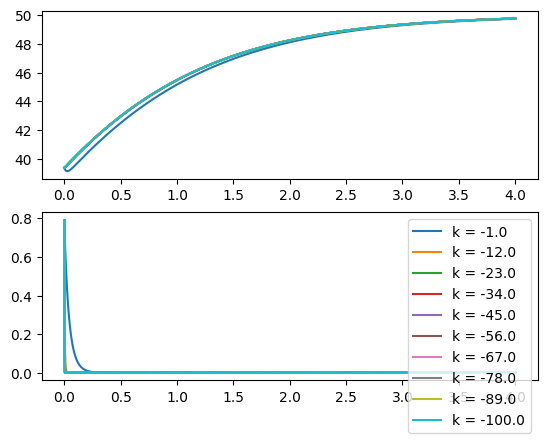

In [6]:
# We need an eigendecomposition
from numpy import linalg 

# Set a constant ER graph to use through this section
er_adj = nx.to_numpy_matrix(nx.erdos_renyi_graph(50, 0.5))

# Generate our DynaNet
G = DynaNet.DynaNet(adj_mtx=er_adj)

# Grab our laplacian matrix
G.generate_incidence()
K = G.incidence_mtx
L = np.dot(K, np.transpose(K))

# Get evals, evecs from adjacency and laplacian
Aevals, Aevecs = linalg.eig(er_adj)
Levals, Levecs = linalg.eig(L)

# Get the PF evals
Amax = np.max(Aevals)
Lmax = np.max(Levals)

# Space diffusion coefficients up to our evals
ks = -np.linspace(1, 100, 10)
v = 0

# Keep ICs constant to compare
f0 = np.random.exponential(size=len(G.vert))

# set up plotting
fig, axs = plt.subplots(2, 1)

for k in ks:
    ds = [k for ii in G.vert]
    vs = [v for ii in G.vert]
    G.solve_ivp(DE, f0, t0, tf, nt, ds, vs)
    
    # set up ploting
    axs[0].plot(
        G.solve_ivp_results.t,
        G.solve_ivp_results.y.sum(axis=0),
        label=f'k = {k}'
    )
    axs[1].plot(
        G.solve_ivp_results.t,
        G.solve_ivp_results.y.std(axis=0),
        label=f'k = {k}'
    )
    plt.legend()

We note that total load decays to its fixed point at roughly the same rate independent of the diffustion coefficient, which is surprising. Same with the standard deviation across nodes.

## Wave Fronts

Now, lets consider tracking a wave front from the KPP equation. A crude approximation can be given by fixing a node with a large amount of tension and tracing it's nearest neighbors. Basically, we can look at the state of the system at any given time, find regions of large gradient, and calculate their distance from the starting point. This is slightly challenging give the smaller, finite, size of graphs, so this analysis will only hold for intermediate times, not too small such that bulk behaviour has not emerged, and not so large that the each graph node has saturated.

So, we will look at the average function over time over the nodes of some distance $R$ away from the initial starting node. 

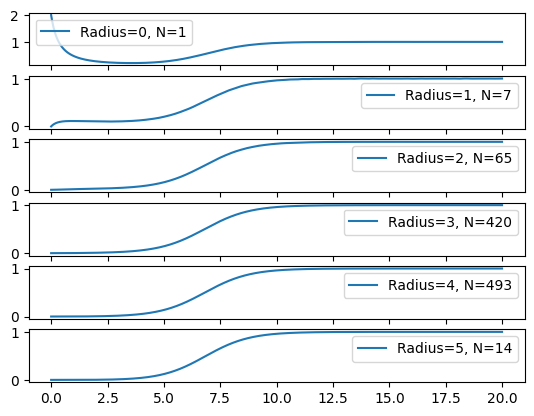

In [7]:
# Generate our ER graph
er_graph = nx.erdos_renyi_graph(1000, 0.009)
er_adj = nx.to_numpy_matrix(er_graph)

# Create DynaNet
G = DynaNet.DynaNet(adj_mtx=er_adj)

# Set up inital conitions
T0 = 2
ks = [-0.25 for ii in G.vert]
vs = [0 for ii in G.vert]
f0 = np.zeros(1000) #0.001*np.random.exponential(size=1000)
f0[0] = T0

t0 = 0
tf = 20
nt = 1000

# Run simulation
G.solve_ivp(DE, f0, t0, tf, nt, ks, vs)
res = G.solve_ivp_results

# compute shortest path lengths from our tension source node
spl = nx.shortest_path_length(er_graph, source=0)
spl = np.array([spl[k] for k in range(1000)])

# set up for plotting
fig, axs = plt.subplots(len(set(spl)), 1)

# Iterate through unique radii
for ii in set(spl):
    # mask on radii and sum for total load at radius ii
    loads = np.dot(np.transpose(res.y), spl==ii)/sum(spl==ii)
    axs[ii].plot(res.t, loads, label=f'Radius={ii}, N={sum(spl==ii)}')

    # Plot legends
    axs[ii].legend()

Frome here, we see the emergence of a wave-like front propogating from the source point. We can try this same thing for a larger grap to see if it continues for larger radii.

In [ ]:
# Generate our ER graph
er_graph = nx.erdos_renyi_graph(10000, 0.01)
er_adj = nx.to_numpy_matrix(er_graph)

# Create DynaNet
G = DynaNet.DynaNet(adj_mtx=er_adj)

# Set up inital conitions
T0 = 20
ks = [-1 for ii in G.vert]
vs = [0 for ii in G.vert]
f0 = np.ones(len(G.vert))
f0[0] = T0

t0 = 0
tf = 2
nt = 100

# Run simulation
G.solve_ivp(DE, f0, t0, tf, nt, ks, vs)
res = G.solve_ivp_results

# compute shortest path lengths from our tension source node
spl = nx.shortest_path_length(er_graph, source=0)
spl = np.array([spl[k] for k in range(10000)])

# set up for plotting
fig, axs = plt.subplots(len(set(spl)), 1)

# Iterate through unique radii
for ii in set(spl):
    # mask on radii and sum for total load at radius ii
    loads = np.dot(np.transpose(res.y), spl==ii)/sum(spl==ii)
    axs[ii].plot(res.t, loads, label=f'Radius={ii}, N={sum(spl==ii)}')

    # Plot legends
    axs[ii].legend()

Even on larger networks, we see a somewhat more pronounced wave front. We can estimate the "wave speed" by tracking that peak point.

In [8]:
for ii in set(spl):
    loads = np.dot(np.transpose(res.y), spl==ii)/sum(spl==ii)
    print(np.where(loads==np.max(loads)))
    
p = np.polyfit([0, 1, 2, 3], [0, 1, 2, 4], deg=1)
p

(array([0], dtype=int64),)
(array([970], dtype=int64),)
(array([986], dtype=int64),)
(array([971], dtype=int64),)
(array([986], dtype=int64),)
(array([971], dtype=int64),)


array([ 1.3, -0.2])

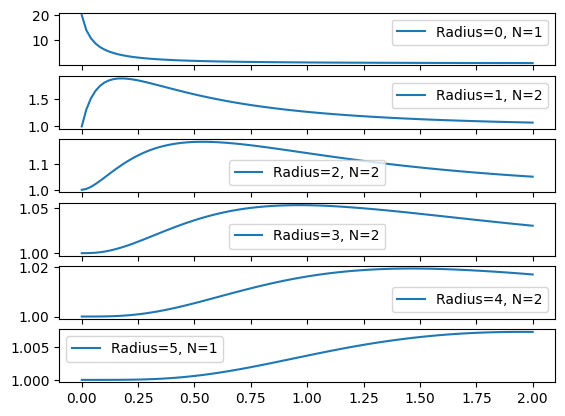

In [9]:
# Create a line graph adjacency matrix
adj = np.roll(np.identity(10), 1)
adj[0][0] = 0
adj = (adj + np.transpose(adj))
adj

# Comply with nx graphs
graph = nx.from_numpy_matrix(adj)

# Create DynaNet
G = DynaNet.DynaNet(adj_mtx=adj)

# Set up inital conitions
T0 = 20
ks = [-1 for ii in G.vert]
vs = [0 for ii in G.vert]
f0 = np.ones(len(G.vert))
f0[len(G.vert)//2] = T0

t0 = 0
tf = 2
nt = 100

# Run simulation
G.solve_ivp(DE, f0, t0, tf, nt, ks, vs)
res = G.solve_ivp_results

# compute shortest path lengths from our tension source node
spl = nx.shortest_path_length(graph, source=len(G.vert)//2)
spl = np.array([spl[k] for k in range(10)])

# set up for plotting
fig, axs = plt.subplots(len(set(spl)), 1)

# Iterate through unique radii
for ii in set(spl):
    # mask on radii and sum for total load at radius ii
    loads = np.dot(np.transpose(res.y), spl==ii)/sum(spl==ii)
    axs[ii].plot(res.t, loads, label=f'Radius={ii}, N={sum(spl==ii)}')

    # Plot legends
    axs[ii].legend()

In [10]:
for ii in set(spl):
    loads = np.dot(np.transpose(res.y), spl==ii)/sum(spl==ii)
    print(np.where(loads==np.max(loads)))
    
p = np.polyfit([0,1,2,3],[0,9,26,48], deg=1)
p

(array([0], dtype=int64),)
(array([9], dtype=int64),)
(array([26], dtype=int64),)
(array([48], dtype=int64),)
(array([72], dtype=int64),)
(array([97], dtype=int64),)


array([16.1, -3.4])

Which estimates our wave speed at $\sim 16$

# Multiplexing

Now we consider a multiplexed element. By multiplex, we refer to a set of parallel graphs that all share a vertex set. Each parallel graph has a set of dynamics on it that may be coupled to some degree. For example, we may consider a set of offline and online dynamics. As a working example, let us consider a set of dynamics on two random network, say parallel Erdos Renyi graphs.

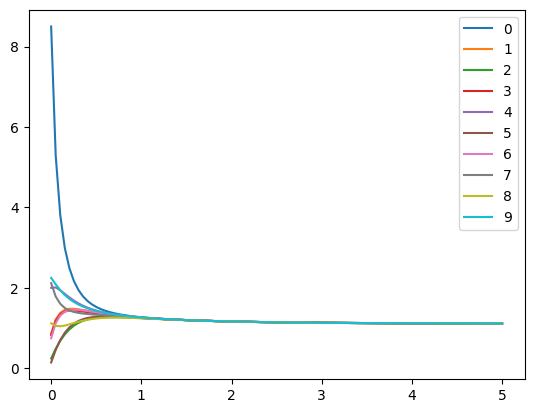

In [11]:
import numpy as np 
from matplotlib import pyplot as plt
import networkx as nx
import DynaNet
import Equations

# Set graph parameters
graph_size = 10
p = .5

# Generate adjacency graphs
online, offline = [nx.to_numpy_array(nx.erdos_renyi_graph(graph_size, p)) for ii in range(2)]

# Create a multiplexed dynamic graph model
MG = DynaNet.MultiplexDynaNet([online, offline])
MG.generate_incidence()
MG.generate_laplacian()
MG.generate_multi_laplacian()

# Set up our multiplexed Fisher-KPP equation
MDE = Equations.MultiplexFisherKPPStep

# Set up equation parameters
ks = np.array([-1 for ii in range(graph_size)] + [-5 for ii in range(graph_size)])
vs = np.zeros(2*graph_size)
epsilon = 0.1
coupling = lambda state: epsilon * state*np.roll(state, graph_size)

# Set up initial conditions
t0 = 0
tf = 5
nt = 100
f0 = 2 * np.random.exponential(size=2*graph_size)

# Run simulation
MG.solve_ivp(MDE, f0, t0, tf, nt, ks, vs, coupling)
res = MG.solve_ivp_results

for ii in range(graph_size):
    plt.plot(res.t, res.y[ii, :], label=f'{ii}')
    plt.legend()
plt.show()

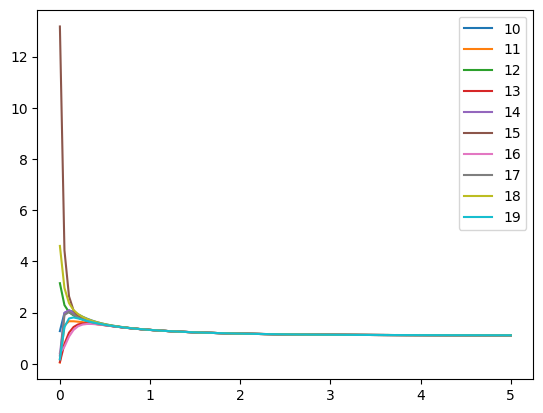

In [12]:
for ii in range(10, 2*graph_size):
    plt.plot(res.t, res.y[ii, :], label=f'{ii}')
    plt.legend()
plt.show()

From this, we see that that nodes on the slower diffusion take longer to equillibrate to the steady state. And the nodes on the faster diffusion network equillibrate far quicker. Now, if we wanted to implement the model seen in Ghazaryan Et. al, 2020, where we implement a tension field and a social unrest field, we simply change the coupling function

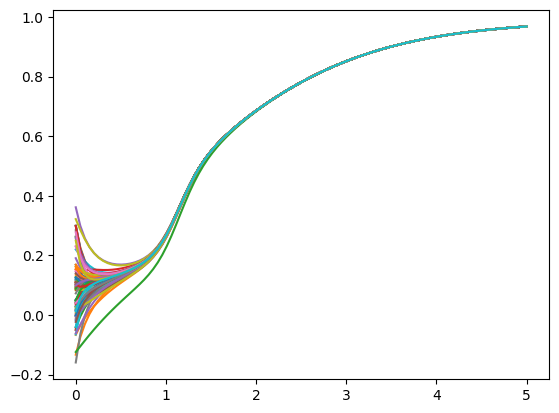

In [13]:
# Set graph parameters
graph_size = 100
p = .09

# Generate adjacency graphs
online, offline = [nx.to_numpy_array(nx.erdos_renyi_graph(graph_size, p)) for ii in range(2)]

# Create a multiplexed dynamic graph model
MG = DynaNet.MultiplexDynaNet([online, offline])
MG.generate_incidence()
MG.generate_laplacian()
MG.generate_multi_laplacian()

# Set up our multiplexed Fisher-KPP equation
MDE = Equations.MultiplexFisherKPPStep

# Set up equation parameters
ks = np.array([-1 for ii in range(graph_size)] + [-5 for ii in range(graph_size)])
vs = np.zeros(2*graph_size)
epsilon = 0.1
def coupling(state):
    u = state[:graph_size]
    v = state[graph_size:]
    u_next = -0.01*u + 1000*u*(1-u)/(1+np.exp(-20*(v-1)))
    v_next = 1-v*(1+u)**2
    return np.concatenate((u_next, v_next))

# Set up initial conditions
t0 = 0
tf = 5
nt = 100
f0 = np.random.normal(1, size=2*graph_size)*0.1

# Run simulation
MG.solve_ivp(MDE, f0, t0, tf, nt, ks, vs, coupling)
res = MG.solve_ivp_results

for ii in range(graph_size):
    plt.plot(res.t, res.y[ii, :], label=f'{ii}')
    #plt.legend()
plt.show()

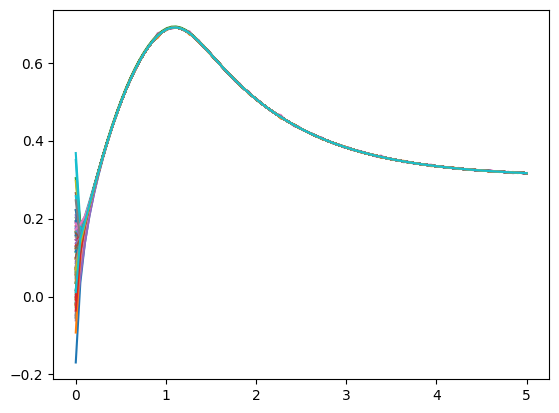

In [14]:
for ii in range(graph_size, 2*graph_size):
    plt.plot(res.t, res.y[ii, :], label=f'{ii}')
    #plt.legend()
plt.show()

To attempt to acurately recreate the paper resultes, let's consider both to be on a line graph. That is node 1 is only connected to node 2 which connects only to node 3 and so on

In [ ]:
# Set graph parameters
graph_size = 1000

# Line graphs
ident = np.identity(graph_size)
adj = np.roll(ident, 1) + np.roll(ident, -1) 
online, offline = adj, adj

# Create a multiplexed dynamic graph model
MG = DynaNet.MultiplexDynaNet([online, offline])
MG.generate_incidence()
MG.generate_laplacian()
MG.generate_multi_laplacian()

# Set up our multiplexed Fisher-KPP equation
MDE = Equations.MultiplexFisherKPPStep

# Set up equation parameters
ks = np.array([-0.0001 for ii in range(graph_size)] + [-1 for ii in range(graph_size)])
vs = np.zeros(2*graph_size)
epsilon = 0.1
def coupling(state):
    u = state[:graph_size]
    v = state[graph_size:]
    u_next = 0.01*(-u + 300*u*(1-u)/(1+np.exp(-20*(v-1))))
    v_next = 1-v*(1+u)**2
    return np.concatenate((u_next, v_next))

# Set up initial conditions
t0 = 0
tf = 5
nt = 100
f0 = np.random.normal(1, size=2*graph_size)*0.1

# Run simulation
MG.solve_ivp(MDE, f0, t0, tf, nt, ks, vs, coupling)
res = MG.solve_ivp_results

for ii in range(graph_size):
    plt.plot(res.t, res.y[ii, :], label=f'{ii}')
    #plt.legend()
plt.show()